# Process and visualize data

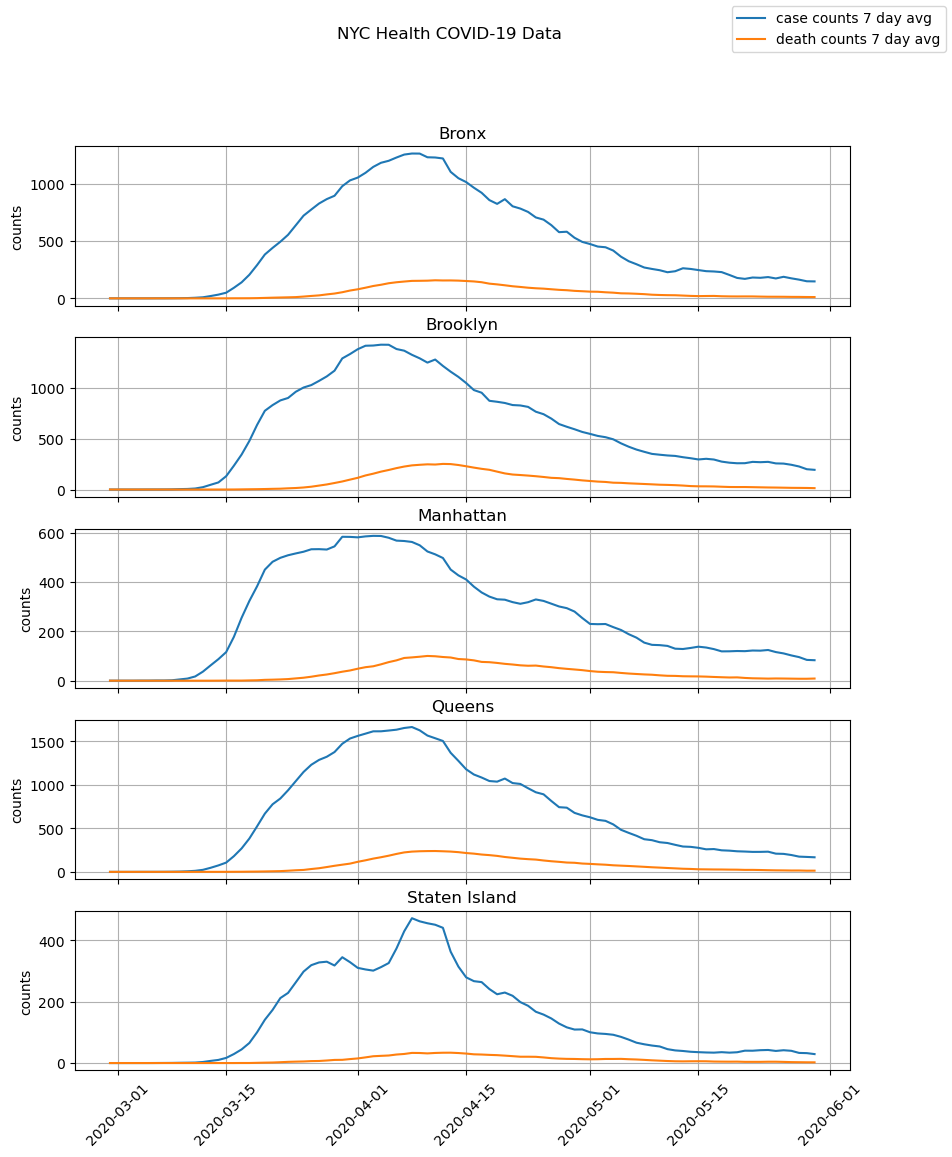

In [2]:
import process_data
from codebook import BOROUGH_FULL_FIPS_DICT
from utils import get_fips_list
import matplotlib.pyplot as plt

death_subset_df, case_subset_df = process_data.process_case_death_data()
fips_list = get_fips_list()

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)

for i, f in enumerate(fips_list):
    ax[i].plot(case_subset_df.loc[case_subset_df['FIPS'] == f, 'date_of_interest'], case_subset_df.loc[case_subset_df['FIPS'] == f, 'CASE_COUNT_7DAY_AVG'].values, '-', label='case counts 7 day avg')
    ax[i].plot(death_subset_df.loc[death_subset_df['FIPS'] == f, 'date_of_interest'], death_subset_df.loc[death_subset_df['FIPS'] == f, 'DEATH_COUNT_7DAY_AVG'].values, '-', label='death counts 7 day avg')
    ax[i].set_title(BOROUGH_FULL_FIPS_DICT[f])
    ax[i].set_ylabel(r'counts')
    ax[i].grid()

plt.xticks(rotation=45)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("NYC Health COVID-19 Data")
fig.savefig("../assets/nyc_health.png")

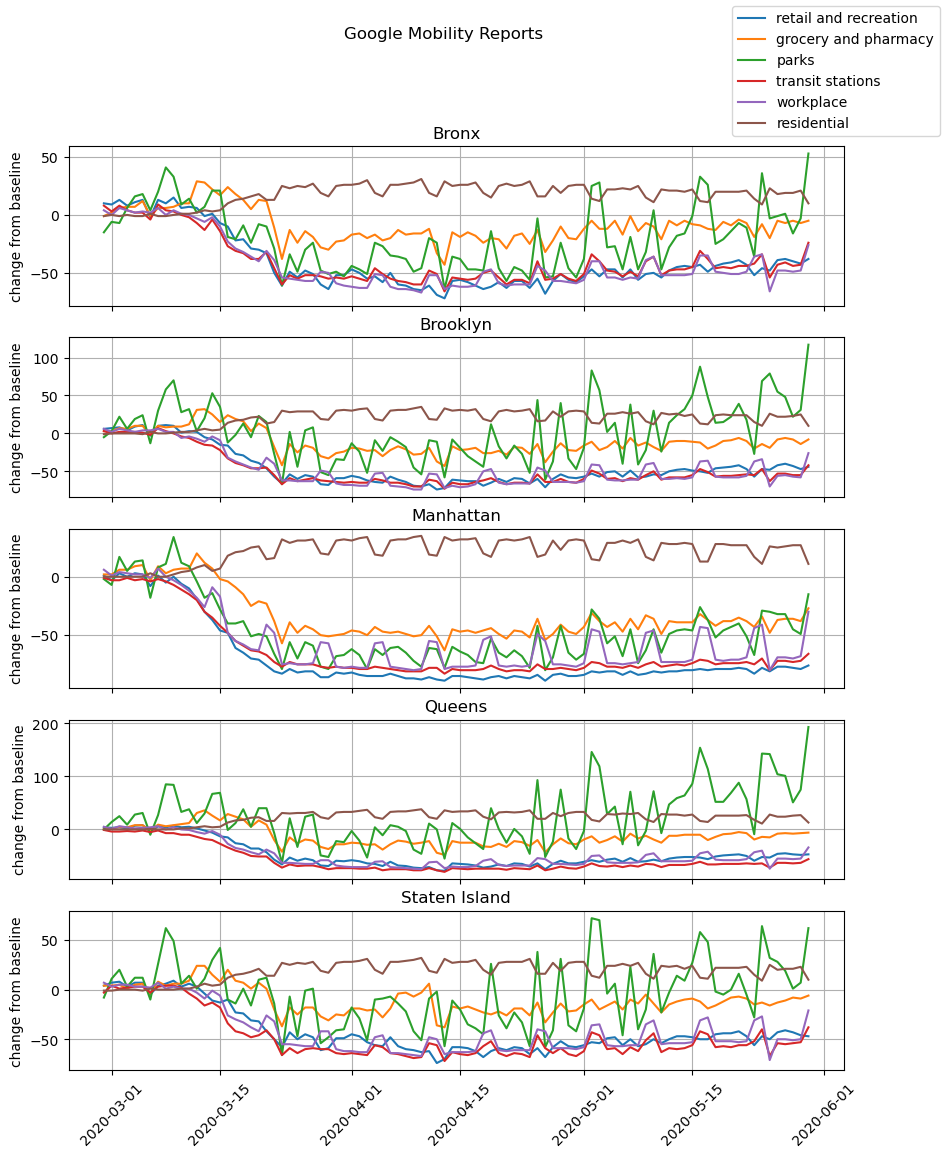

In [3]:
nyc_mobility_report_df = process_data.process_mobility_report()

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)

for i, f in enumerate(fips_list):
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'retail_and_recreation_percent_change_from_baseline'], label='retail and recreation')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'grocery_and_pharmacy_percent_change_from_baseline'], label='grocery and pharmacy')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'parks_percent_change_from_baseline'], label='parks')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'transit_stations_percent_change_from_baseline'], label='transit stations')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'workplaces_percent_change_from_baseline'], label='workplace')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'residential_percent_change_from_baseline'], label='residential')

    ax[i].grid()
    ax[i].set_title(BOROUGH_FULL_FIPS_DICT[f])
    ax[i].set_ylabel(r'change from baseline')

plt.xticks(rotation=45)
handles, labels = ax[0].get_legend_handles_labels()
fig.suptitle("Google Mobility Reports")
fig.legend(handles, labels, loc='upper right')
fig.savefig("../assets/google_mobility_reports.png")

SafeGraph Data Preprocessing

Raw safegraph data first processed through ``src/colab_process_safegraph_mobility.ipynb``. Raw data not shared due to data use agreement with research group. The main preprocessing steps were:
- Map postal code to borough
- Drop rows with not postal code/ borough (around 2% of rows)
- Safegraph data is weekly
- Aggregate `visitor_home_aggregation` from destination to origin

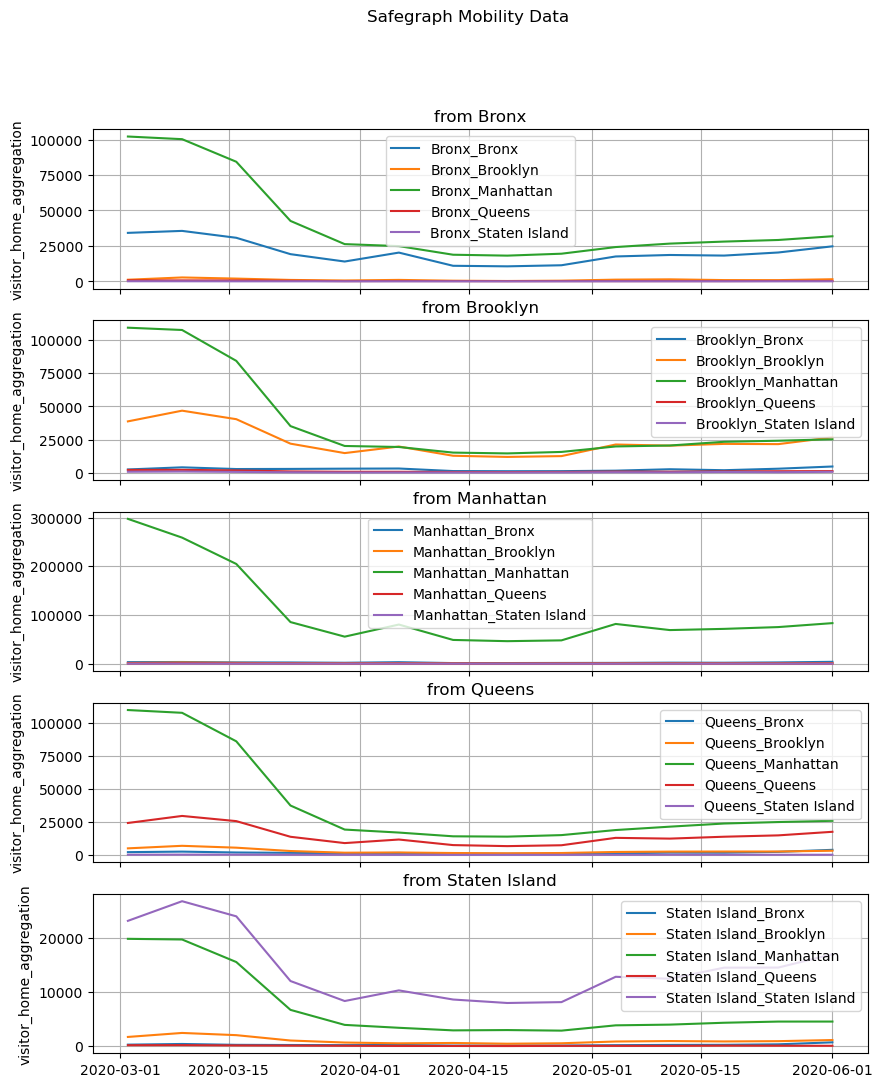

In [4]:
import os
import glob
from utils import get_date_range
import pandas as pd
import numpy as np

mobility_files = glob.glob("../data/raw/*.csv")
mobility_dates = [os.path.basename(f).split("_")[0] for f in mobility_files]
mobility_dates = pd.to_datetime(mobility_dates)
mobility_dates = mobility_dates.sort_values()

START_DATE = "02/29/2020"
END_DATE = "05/30/2020"

dates = get_date_range(START_DATE, END_DATE)

day_mobility_dict = dict()

for d in dates:
    next_sunday = d + pd.offsets.Week(n=0, weekday=0)
    day_key = d.strftime("%Y-%m-%d")
    day_mobility_dict[day_key] = next_sunday.strftime("%Y-%m-%d") + "_mobility.csv"

mobility_files = np.unique(list(day_mobility_dict.values()))

df_list = []

for file in mobility_files:
    df_list.append(pd.read_csv(f"../data/raw/mobility/{file}"))

mobility_df = pd.concat(df_list)
mobility_df["path"] = mobility_df["origin"] + "_" + mobility_df["destination"]
mobility_df["date"] = pd.to_datetime(mobility_df["end"])

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)


for i, o in enumerate(mobility_df["origin"].unique()):
    paths = mobility_df.loc[mobility_df.origin == o, "path"].unique()
    for path in paths:
        ax[i].plot(
            mobility_df.loc[mobility_df['path'] == path, 'date'],
            mobility_df.loc[mobility_df['path'] == path, 'visitor_home_aggregation'].values, '-', label=path)
    ax[i].set_title(f"from {o}")
    ax[i].set_ylabel(r'visitor_home_aggregation')
    ax[i].grid()
    ax[i].legend()

fig.suptitle("Safegraph Mobility Data")
fig.savefig("../assets/safegraph.png")


In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = process_data.create_torch_geometric_data("gcn", device)
data

2300 spatial edges
2975 temporal edges


5275it [00:01, 4364.44it/s]


Processed data saved to ../data/processed/gcn/


Data(x=[460, 22], edge_index=[2, 5275], y=[460], edge_weight=[5275], train_mask=[460], test_mask=[460])

In [6]:
delta_data = process_data.create_torch_geometric_data("gcn_delta", device, predict_delta=True)
delta_data

2300 spatial edges
2975 temporal edges


5275it [00:04, 1314.18it/s]

Processed data saved to ../data/processed/gcn_delta/


Data(x=[460, 22], edge_index=[2, 5275], y=[460], edge_weight=[5275], train_mask=[460], test_mask=[460])

In [7]:
## plot as a network (not informative figure)

# from torch_geometric.data import Data


# mask = np.zeros(data.x.size(0))
# mask[:5] = 1
# mask = torch.tensor(np.array(mask), dtype=torch.bool)

# first_day = Data(
#     x=data.x[mask],
#     y=data.y[mask],
#     edge_index=data.edge_index[mask],
#     edge_weight=data.edge_weight[mask],
# )

# from utils import get_node_borough, get_node_pos
# pos = {idx : get_node_pos("gcn", idx) for idx in range(data.x.shape[0])}

# import networkx as nx
# from torch_geometric.utils import to_networkx, mask_select

# # Create a graph
# G = to_networkx(data)

# # Draw the graph
# nx.draw(G, pos, node_size=5, arrowsize=1, alpha=0.1)

# # color by borough

# # put them on a map

# # order them temporally

# # page rank on contact network

# import plotly.graph_objects as go


# edge_x = []
# edge_y = []
# for edge in G.edges():
#     x0, y0 = pos[edge[0]]
#     x1, y1 = pos[edge[1]]
#     edge_x.append(x0)
#     edge_x.append(x1)
#     edge_x.append(None)
#     edge_y.append(y0)
#     edge_y.append(y1)
#     edge_y.append(None)

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines')

# node_x = []
# node_y = []
# for node in G.nodes():
#     x, y = pos[node]
#     node_x.append(x)
#     node_y.append(y)

# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers',
#     hoverinfo='text',
#     marker=dict(
#         showscale=True,
#         # colorscale options
#         #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
#         #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
#         #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#         colorscale='YlGnBu',
#         reversescale=True,
#         color=[],
#         size=10,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
#         line_width=2))

# fig = go.Figure(data=[edge_trace, node_trace],
#              layout=go.Layout(
#                 titlefont_size=16,
#                 showlegend=False,
#                 hovermode='closest',
#                 margin=dict(b=20,l=5,r=5,t=40),
#                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
#                 )
# fig.show()

# Reproduce Original Paper

##  GCN

In [11]:
from tqdm import tqdm
from model import GCN, RMSLELoss
from torch_geometric.nn import summary


graph = data.to(device)
print(graph)

model     = GCN().to(device)
print(summary(model, graph.x, graph.edge_index))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)
criterion = RMSLELoss()

def train():
	model.train()
	optimizer.zero_grad()
	out, _ = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out, _  = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

train_loss = []
test_loss = []
for epoch in tqdm(range(1_000_000)):
	loss = train()
	train_loss.append(loss.cpu().detach().numpy())
	loss = test()
	test_loss.append(loss.cpu().detach().numpy())

print("final test loss: {}".format(test_loss[-1]))

Data(x=[460, 22], edge_index=[2, 5275], y=[460], edge_weight=[5275], train_mask=[460], test_mask=[460])
+---------------------+----------------------+--------------------+----------+
| Layer               | Input Shape          | Output Shape       | #Param   |
|---------------------+----------------------+--------------------+----------|
| GCN                 | [460, 22], [2, 5275] | [460, 1], [460, 1] | 3,937    |
| ├─(MLP_embed)Linear | [460, 22]            | [460, 32]          | 736      |
| ├─(conv1)GCNConv    | [460, 32], [2, 5275] | [460, 32]          | 1,056    |
| ├─(conv2)GCNConv    | [460, 64], [2, 5275] | [460, 32]          | 2,080    |
| ├─(MLP_pred)Linear  | [460, 64]            | [460, 1]           | 65       |
+---------------------+----------------------+--------------------+----------+


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [1:33:58<00:00, 177.35it/s]

final test loss: 0.06851895898580551


In [12]:
model.eval()
out, _  = model(graph.x, graph.edge_index)
print("train loss", criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask]))
print("test loss", criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask]))
print("train corr", torch.corrcoef(torch.stack((out[graph.train_mask].squeeze(), graph.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((out[graph.test_mask].squeeze(), graph.y[graph.test_mask])))[0,1])
y_test = graph.y[graph.test_mask].cpu().numpy()
out_test = out[graph.test_mask].detach().cpu().numpy()

y_train = graph.y[graph.train_mask].cpu().numpy()
out_train = out[graph.train_mask].detach().cpu().numpy()



train loss tensor(0.0586, device='cuda:0', grad_fn=<SqrtBackward0>)
test loss tensor(0.0685, device='cuda:0', grad_fn=<SqrtBackward0>)
train corr tensor(0.9985, device='cuda:0', grad_fn=<SelectBackward0>)
test corr tensor(0.9958, device='cuda:0', grad_fn=<SelectBackward0>)


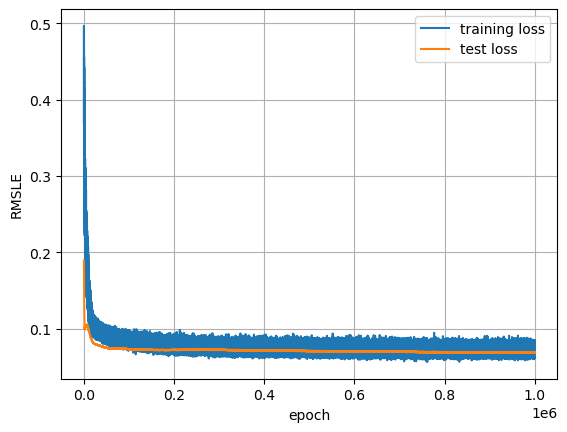

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_loss, label='training loss')
ax.plot(test_loss, label='test loss')
ax.set_xlabel('epoch')
ax.set_ylabel('RMSLE')
ax.grid()
ax.legend()

Text(0.5, 1.0, 'Training set')

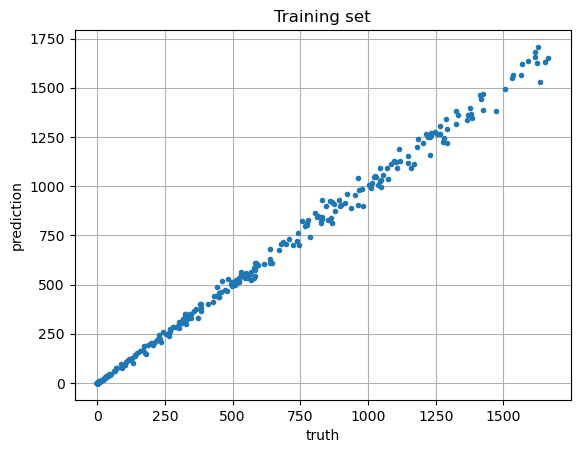

In [14]:
fig, ax = plt.subplots()
ax.plot(y_train, out_train, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Training set')

Text(0.5, 1.0, 'Test set')

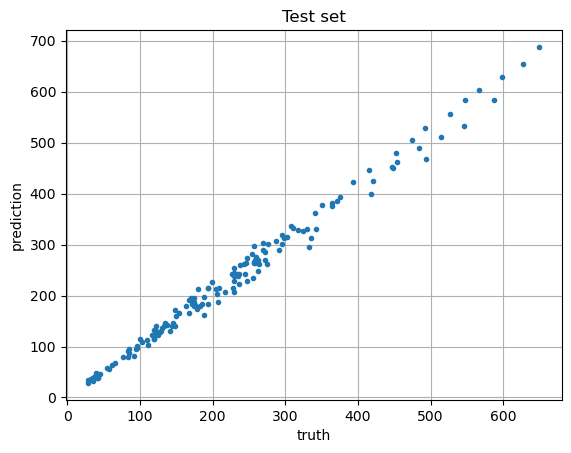

In [15]:
fig, ax = plt.subplots()
ax.plot(y_test, out_test, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Test set')

In [19]:
import pandas as pd
import numpy as np

node_dict = process_data.create_node_key()

pred_df = pd.DataFrame()
pred_df['key'] = np.array(list(node_dict.keys()))[np.where(np.array(graph.test_mask.cpu().numpy())==1)]
pred_df['truth'] = y_test
pred_df['pred'] = out_test

pred_df[['fips','date']] = pred_df['key'].str.split('-',n=1, expand=True)
pred_df['date'] = pd.to_datetime(pred_df['date'])

train_df = pd.DataFrame()
train_df['key'] = np.array(list(node_dict.keys()))[np.where(np.array(graph.train_mask.cpu().numpy())==1)]
train_df['truth'] = y_train
train_df['pred'] = out_train

train_df[['fips','date']] = train_df['key'].str.split('-',n=1, expand=True)
train_df['date'] = pd.to_datetime(train_df['date'])

(array([18322., 18336., 18353., 18367., 18383., 18397., 18414.]),
 [Text(18322.0, 0, '2020-03-01'),
  Text(18336.0, 0, '2020-03-15'),
  Text(18353.0, 0, '2020-04-01'),
  Text(18367.0, 0, '2020-04-15'),
  Text(18383.0, 0, '2020-05-01'),
  Text(18397.0, 0, '2020-05-15'),
  Text(18414.0, 0, '2020-06-01')])

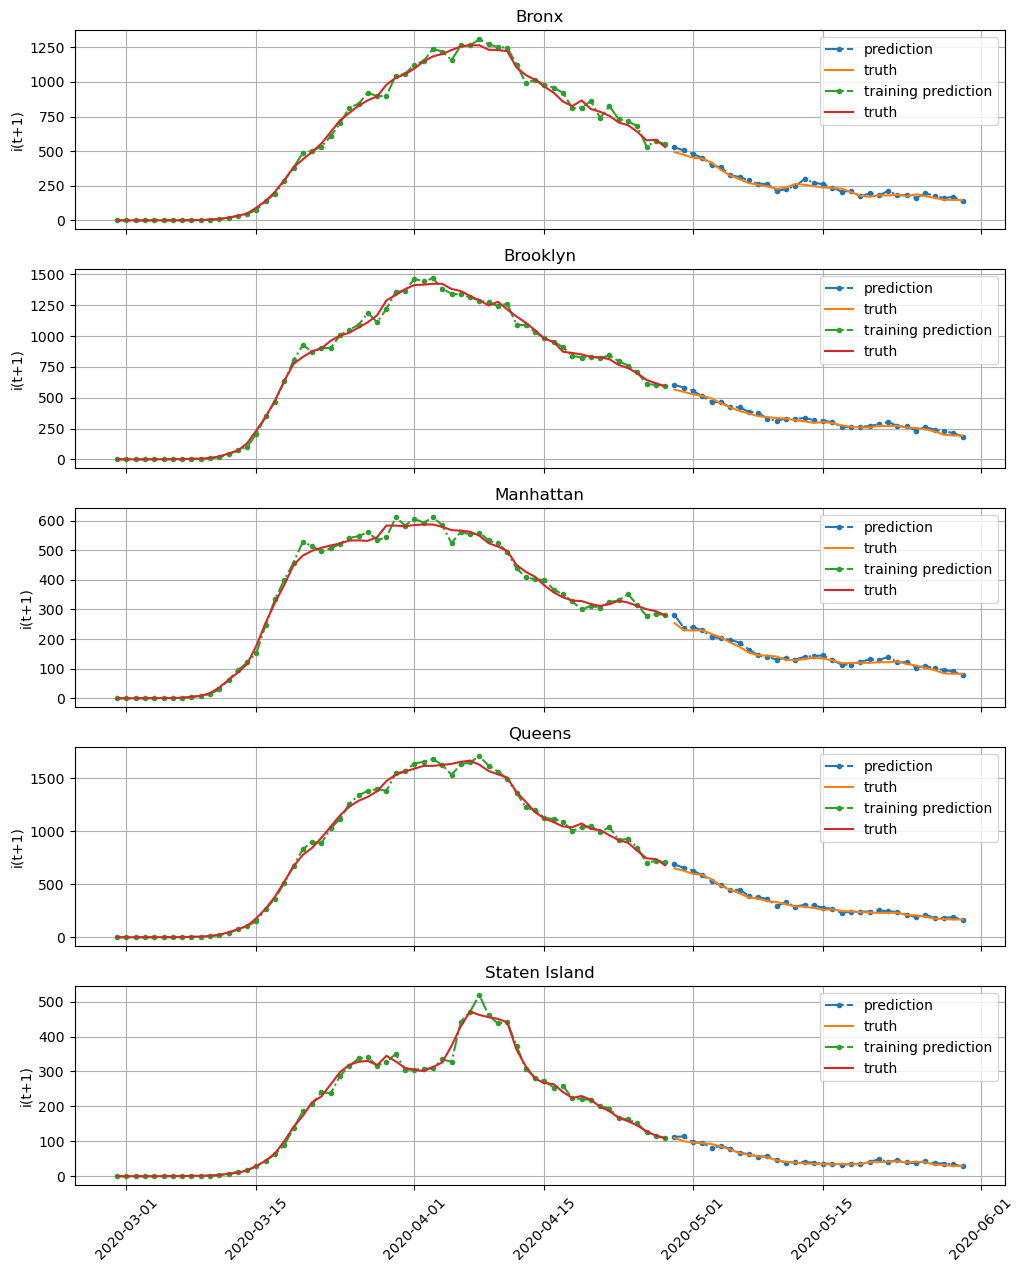

In [20]:
fig, ax = plt.subplots(5, figsize=(12,15), sharex=True)

for i, f in enumerate(fips_list):
    ax[i].plot(pred_df.loc[pred_df['fips'] == str(f), 'date'], pred_df.loc[pred_df['fips'] == str(f), 'pred'].values, '.-.', label='prediction')
    ax[i].plot(pred_df.loc[pred_df['fips'] == str(f), 'date'], pred_df.loc[pred_df['fips'] == str(f), 'truth'].values, '-', label='truth')

    ax[i].plot(train_df.loc[train_df['fips'] == str(f), 'date'], train_df.loc[train_df['fips'] == str(f), 'pred'].values, '.-.', label='training prediction')
    ax[i].plot(train_df.loc[train_df['fips'] == str(f), 'date'], train_df.loc[train_df['fips'] == str(f), 'truth'].values, '-', label='truth')
    
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(BOROUGH_FULL_FIPS_DICT[f])
    ax[i].set_ylabel(r'i(t+1)')

plt.xticks(rotation=45)


In [21]:
# predict case delta metrics

model.eval()
_, delta_pred  = model(graph.x, graph.edge_index)
print("train loss", criterion(torch.abs(delta_pred[graph.train_mask].squeeze()), torch.abs(delta_data.y[graph.train_mask])))
print("test loss", criterion(torch.abs(delta_pred[graph.test_mask].squeeze()), torch.abs(delta_data.y[graph.test_mask])))
print("train corr", torch.corrcoef(torch.stack((delta_pred[graph.train_mask].squeeze(), delta_data.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((delta_pred[graph.test_mask].squeeze(), delta_data.y[graph.test_mask])))[0,1])

train loss tensor(0.9740, device='cuda:0', grad_fn=<SqrtBackward0>)
test loss tensor(1.2066, device='cuda:0', grad_fn=<SqrtBackward0>)
train corr tensor(0.8317, device='cuda:0', grad_fn=<SelectBackward0>)
test corr tensor(0.5270, device='cuda:0', grad_fn=<SelectBackward0>)


## Previous Cases

In [15]:
from model import prevCase

model     = prevCase().to(device)
criterion = RMSLELoss()

def train():
	model.train()
	out = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	return loss

def test():
	model.eval()
	out  = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

train_loss = []
test_loss = []
for epoch in tqdm(range(1)):
	loss = train()
	train_loss.append(loss.cpu().detach().numpy())
	loss = test()
	test_loss.append(loss.cpu().detach().numpy())

print("final test loss: {}".format(test_loss[-1]))

100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1597.83it/s]

final test loss: 0.06263869255781174


In [16]:
model.eval()
out  = model(graph.x, graph.edge_index)
print("train loss", criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask]))
print("test loss", criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask]))
print("train corr", torch.corrcoef(torch.stack((out[graph.train_mask].squeeze(), graph.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((out[graph.test_mask].squeeze(), graph.y[graph.test_mask])))[0,1])

train loss tensor(0.2221)
test loss tensor(0.0626)
train corr tensor(0.9961)
test corr tensor(0.9977)


In [17]:

print("train loss", criterion(torch.zeros(300), torch.abs(delta_data.y[graph.train_mask])))
print("val loss", criterion(torch.zeros(160), torch.abs(delta_data.y[graph.test_mask])))
print("train corr", torch.corrcoef(torch.stack((torch.zeros(300), delta_data.y[graph.train_mask])))[0,1])
print("val corr", torch.corrcoef(torch.stack((torch.zeros(160), delta_data.y[graph.test_mask])))[0,1])

train loss tensor(3.0560)
val loss tensor(2.3047)
train corr tensor(nan)
val corr tensor(nan)


## Previous Delta

In [18]:
from model import prevDelta

model     = prevDelta().to(device)
# criterion = torch.nn.MSELoss()
criterion = RMSLELoss()

def train():
	model.train()
	out, _ = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	return loss

def test():
	model.eval()
	out, _  = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

train_loss = []
test_loss = []
for epoch in tqdm(range(1)):
	loss = train()
	train_loss.append(loss.cpu().detach().numpy())
	loss = test()
	test_loss.append(loss.cpu().detach().numpy())

print("final test loss: {}".format(test_loss[-1]))

100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.58it/s]

final test loss: 0.06058723106980324


In [19]:
model.eval()
out, _  = model(graph.x, graph.edge_index)
print("train loss", criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask]))
print("test loss", criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask]))
print("train corr", torch.corrcoef(torch.stack((out[graph.train_mask].squeeze(), graph.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((out[graph.test_mask].squeeze(), graph.y[graph.test_mask])))[0,1])

train loss tensor(0.1098)
test loss tensor(0.0606)
train corr tensor(0.9986)
test corr tensor(0.9968)


In [20]:
model.eval()
_, pred_delta  = model(graph.x, graph.edge_index)
print("train loss", criterion(torch.abs(pred_delta[graph.train_mask].squeeze()), torch.abs(delta_data.y[graph.train_mask])))
print("test loss", criterion(torch.abs(pred_delta[graph.test_mask].squeeze()), torch.abs(delta_data.y[graph.test_mask])))
print("train corr", torch.corrcoef(torch.stack((pred_delta[graph.train_mask].squeeze(), delta_data.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((pred_delta[graph.test_mask].squeeze(), delta_data.y[graph.test_mask])))[0,1])

train loss tensor(0.8331)
test loss tensor(0.9174)
train corr tensor(0.8223)
test corr tensor(0.6210)


# GCN Tuned Hyperparams

In [29]:
import pandas as pd

gcn_results = pd.read_csv("experiments/cgnn/results.csv")

gcn_results.iloc[gcn_results.test_loss.idxmin()]

dropout             0.100000
base_lr             0.010000
max_epoch       10000.000000
weight_decay        0.000500
train_loss          0.052950
test_loss           0.063949
Name: 165, dtype: float64

In [35]:
from tqdm import tqdm
from model import GCN, RMSLELoss
from torch_geometric.nn import summary

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph = process_data.create_torch_geometric_data("gcn", device)

model     = GCN(dropout=0.1).to(device)
print(summary(model, graph.x, graph.edge_index))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = RMSLELoss()

def train():
	model.train()
	optimizer.zero_grad()
	out, _ = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out, _  = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

train_loss = []
test_loss = []
for epoch in tqdm(range(100_000)):
	loss = train()
	train_loss.append(loss.cpu().detach().numpy())
	loss = test()
	test_loss.append(loss.cpu().detach().numpy())

print("final test loss: {}".format(test_loss[-1]))

2300 spatial edges
2975 temporal edges


5275it [00:01, 4506.30it/s]


Processed data saved to ../data/processed/gcn/
+---------------------+----------------------+--------------------+----------+
| Layer               | Input Shape          | Output Shape       | #Param   |
|---------------------+----------------------+--------------------+----------|
| GCN                 | [460, 22], [2, 5275] | [460, 1], [460, 1] | 3,937    |
| ├─(MLP_embed)Linear | [460, 22]            | [460, 32]          | 736      |
| ├─(conv1)GCNConv    | [460, 32], [2, 5275] | [460, 32]          | 1,056    |
| ├─(conv2)GCNConv    | [460, 64], [2, 5275] | [460, 32]          | 2,080    |
| ├─(MLP_pred)Linear  | [460, 64]            | [460, 1]           | 65       |
+---------------------+----------------------+--------------------+----------+


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:47<00:00, 245.33it/s]

final test loss: 0.0604608878493309


In [38]:
model.eval()
out, _  = model(graph.x, graph.edge_index)
print("train loss", criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask]))
print("test loss", criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask]))
print("train corr", torch.corrcoef(torch.stack((out[graph.train_mask].squeeze(), graph.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((out[graph.test_mask].squeeze(), graph.y[graph.test_mask])))[0,1])
y_test = graph.y[graph.test_mask].cpu().numpy()
out_test = out[graph.test_mask].detach().cpu().numpy()

y_train = graph.y[graph.train_mask].cpu().numpy()
out_train = out[graph.train_mask].detach().cpu().numpy()

train loss tensor(0.0408, grad_fn=<SqrtBackward0>)
test loss tensor(0.0605, grad_fn=<SqrtBackward0>)
train corr tensor(0.9990, grad_fn=<SelectBackward0>)
test corr tensor(0.9970, grad_fn=<SelectBackward0>)


In [40]:
# predict case delta metrics
delta_data = process_data.create_torch_geometric_data("gcn_delta", device, predict_delta=True)

model.eval()
_, delta_pred  = model(graph.x, graph.edge_index)
print("train loss", criterion(torch.abs(delta_pred[graph.train_mask].squeeze()), torch.abs(delta_data.y[graph.train_mask])))
print("test loss", criterion(torch.abs(delta_pred[graph.test_mask].squeeze()), torch.abs(delta_data.y[graph.test_mask])))
print("train corr", torch.corrcoef(torch.stack((delta_pred[graph.train_mask].squeeze(), delta_data.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((delta_pred[graph.test_mask].squeeze(), delta_data.y[graph.test_mask])))[0,1])

2300 spatial edges
2975 temporal edges


5275it [00:01, 4549.37it/s]

Processed data saved to ../data/processed/gcn_delta/
train loss tensor(0.8469, grad_fn=<SqrtBackward0>)
test loss tensor(1.0098, grad_fn=<SqrtBackward0>)
train corr tensor(0.8854, grad_fn=<SelectBackward0>)
test corr tensor(0.6498, grad_fn=<SelectBackward0>)


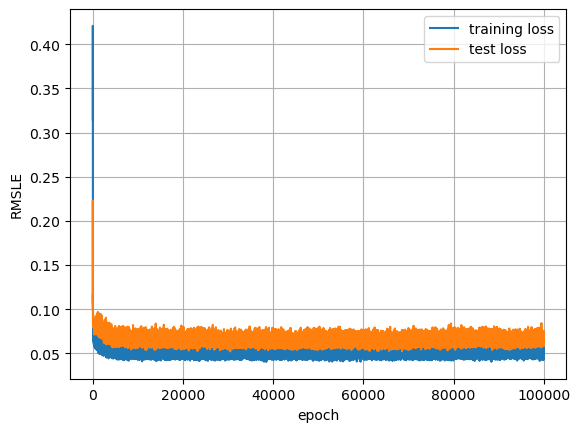

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_loss, label='training loss')
ax.plot(test_loss, label='test loss')
ax.set_xlabel('epoch')
ax.set_ylabel('RMSLE')
ax.grid()
ax.legend()

# Temporal DCRNN
Did not end up using (along with several other architectures that I tested out)

In [1]:
import process_data

import importlib
importlib.reload(process_data)

temporal_data = process_data.create_torch_geometric_temporal_data()
temporal_data

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 384.72it/s]


In [2]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(temporal_data, train_ratio=60/92)

In [3]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import DCRNN,GConvGRU,GConvLSTM,EvolveGCNH,EvolveGCNO,TGCN,A3TGCN,STConv
from torch_geometric.nn import GCNConv

NODE_FEATURES = 22
OUT_DIM = 1
DROPOUT = 0.1


class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.MLP_embed = nn.Linear(node_features, 32)
        self.recurrent = DCRNN(32, 32, 1)
        self.MLP_pred = nn.Linear(32, OUT_DIM)

    def forward(self, x, edge_index, edge_weight):
        h = self.MLP_embed(x)
        h = F.dropout(h, p=DROPOUT, training=self.training)
        
        h = self.recurrent(h, edge_index, edge_weight)
        h = F.dropout(h, p=DROPOUT, training=self.training)
        h = h.relu()
        
        h = self.MLP_pred(h)
        h = h + x[:, 1].unsqueeze(1)
        out = h.relu()

        return out


In [4]:
from tqdm import tqdm
from model import RMSLELoss

model = RecurrentGCN(node_features = 22)
# model = AttentionGCN(node_features=22)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = RMSLELoss()

model.train()

train_loss = []
test_loss = []

for epoch in tqdm(range(1000)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + criterion(y_hat.squeeze(), snapshot.y)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(cost.cpu().detach().numpy())
    

print(cost)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.91it/s]

tensor(0.0665, grad_fn=<DivBackward0>)


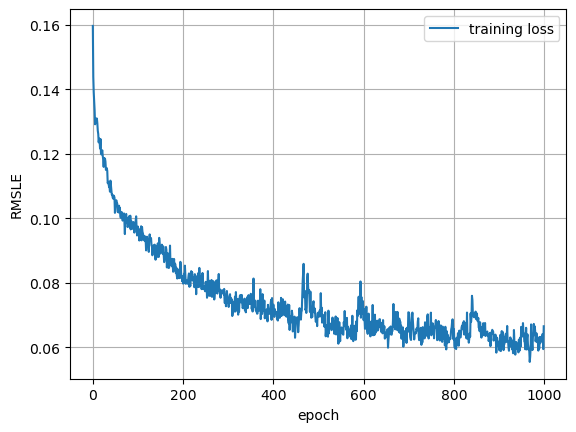

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_loss, label='training loss')
# ax.plot(test_loss, label='training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('RMSLE')
ax.grid()
ax.legend()

In [6]:
model.eval()
cost = 0
y_hat_list = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    y_hat_list.append(y_hat.detach().numpy())
    cost = cost + criterion(y_hat.squeeze(), snapshot.y)
cost = cost / (time+1)
cost = cost.item()
print("RMSLE: {:.4f}".format(cost))

RMSLE: 0.1148


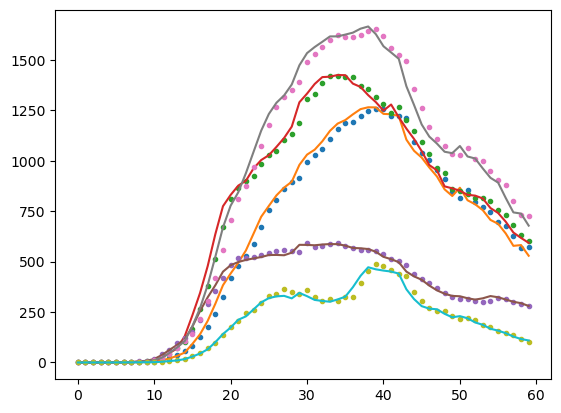

In [7]:
yhat_list = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).detach().numpy() for time, snapshot in enumerate(train_dataset)]
yhat_array = np.array(yhat_list).squeeze()
y_array = np.array([snapshot.y for snapshot in train_dataset])

for i in range(yhat_array.shape[1]):
    plt.plot(yhat_array[:,i], '.')
    plt.plot(y_array[:,i])

# A3TGCN

In [54]:
pd.read_csv("experiments/a3tgcn/results.csv")

,periods,out_channels,dropout,base_lr,train_loss,test_loss
0,3,16,0.001,0.00001,0.133224,0.053947
1,3,16,0.001,0.00010,0.119701,0.054375
2,3,16,0.001,0.00100,0.081604,0.067243
3,3,16,0.010,0.00001,0.139653,0.053305
4,3,16,0.010,0.00010,0.124591,0.053164


In [55]:
from model import AttentionGCN

model = AttentionGCN(node_features=22, periods=3, dropout=0.010, out_channels=16)
print(summary(
    model,
    torch.stack([snapshot.x for snapshot in train_dataset[7-model.periods:7]], dim=2),
    train_dataset[0].edge_index,
    train_dataset[0].edge_attr))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = RMSLELoss()

model.train()

train_loss = []
test_loss = []

for epoch in tqdm(range(1000)):
    cost = 0
    for t in range(model.periods, train_dataset.snapshot_count):
        snapshots = train_dataset[t-model.periods:t]
        y_hat, _ = model(torch.stack([snapshot.x for snapshot in snapshots], dim=2), snapshots[-1].edge_index, snapshots[-1].edge_attr)
        cost = cost + criterion(y_hat.squeeze(), snapshots[-1].y)
    cost = cost / (t+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss.append(cost.cpu().detach().numpy())
    
print(cost)


+---------------------+---------------------------+----------------+----------+
| Layer               | Input Shape               | Output Shape   | #Param   |
|---------------------+---------------------------+----------------+----------|
| AttentionGCN        | [5, 22, 3], [2, 25], [25] | [5, 1], [5, 1] | 2,708    |
| ├─(attention)A3TGCN | [5, 22, 3], [2, 25], [25] | [5, 16]        | 2,691    |
| ├─(MLP_pred)Linear  | [5, 16]                   | [5, 1]         | 17       |
+---------------------+---------------------------+----------------+----------+


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00, 10.00it/s]

tensor(0.1169, grad_fn=<DivBackward0>)


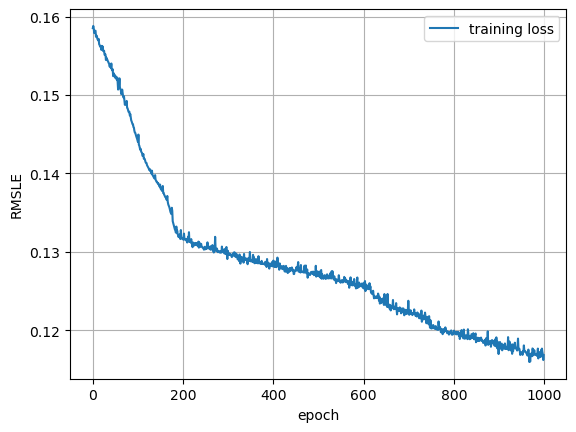

In [56]:
fig, ax = plt.subplots()

ax.plot(train_loss, label='training loss')
# ax.plot(test_loss, label='training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('RMSLE')
ax.grid()
ax.legend()

In [88]:
model.eval()
cost = 0
y_array_list = []
y_hat_list = []
for t in range(model.periods, test_dataset.snapshot_count):
    snapshots = test_dataset[t-model.periods:t]
    y_hat, _ = model(torch.stack([snapshot.x for snapshot in snapshots], dim=2), snapshots[-1].edge_index, snapshots[-1].edge_attr)
    y_hat_list.append(y_hat.detach().numpy())
    y_array_list.append(snapshots[-1].y.detach().numpy())
    cost = cost + criterion(y_hat.squeeze(), snapshots[-1].y)
cost = cost / (t+1)
test_loss = cost.item()
print("RMSLE: {:.4f}".format(cost))

test_yhat_array = torch.tensor(y_hat_list).flatten().squeeze()
test_y_array = torch.tensor(y_array_list).flatten().squeeze()

RMSLE: 0.0550


In [89]:
yhat_list = []
y_array_list = []
for t in range(model.periods, train_dataset.snapshot_count):
    snapshots = train_dataset[t-model.periods:t]
    y_hat, _ = model(torch.stack([snapshot.x for snapshot in snapshots], dim=2), snapshots[-1].edge_index, snapshots[-1].edge_attr)
    yhat_list.append(y_hat.detach().numpy())
    y_array_list.append(snapshots[-1].y.detach().numpy())
train_yhat_array = torch.tensor(yhat_list).flatten().squeeze()
train_y_array = torch.tensor(y_array_list).flatten().squeeze()

In [90]:
print("train loss", train_loss[-1])
print("test loss", test_loss)
print("train corr", torch.corrcoef(torch.stack((train_yhat_array, train_y_array)))[0,1])
print("test corr", torch.corrcoef(torch.stack((test_yhat_array, test_y_array)))[0,1])

train loss 0.11686297
test loss 0.05497037619352341
train corr tensor(0.9960)
test corr tensor(0.9972)


In [119]:
# predict case delta metrics

model.eval()

delta_pred_list = []
for t in range(model.periods, train_dataset.snapshot_count):
    snapshots = train_dataset[t-model.periods:t]
    _, delta_pred = model(torch.stack([snapshot.x for snapshot in snapshots], dim=2), snapshots[-1].edge_index, snapshots[-1].edge_attr)
    delta_pred_list.append(delta_pred.detach().numpy())
train_delta_pred = torch.tensor(delta_pred_list)

delta_pred_list = []
for t in range(model.periods, test_dataset.snapshot_count):
    snapshots = test_dataset[t-model.periods:t]
    _, delta_pred = model(torch.stack([snapshot.x for snapshot in snapshots], dim=2), snapshots[-1].edge_index, snapshots[-1].edge_attr)
    delta_pred_list.append(delta_pred.detach().numpy())
test_delta_pred = torch.tensor(delta_pred_list)

criterion = RMSLELoss()

print("train loss", criterion(torch.abs(train_delta_pred.flatten().squeeze()), torch.abs(delta_data.y[graph.train_mask][15:])))
print("test loss", criterion(torch.abs(test_delta_pred.flatten().squeeze()), torch.abs(delta_data.y[graph.test_mask][15:])))
print("train corr", torch.corrcoef(torch.stack((train_delta_pred.flatten().squeeze(), delta_data.y[graph.train_mask][15:])))[0,1])
print("test corr", torch.corrcoef(torch.stack((test_delta_pred.flatten().squeeze(), delta_data.y[graph.test_mask][:-15])))[0,1])

train loss tensor(2.7544)
test loss tensor(2.0066)
train corr tensor(0.6538)
test corr tensor(0.4010)


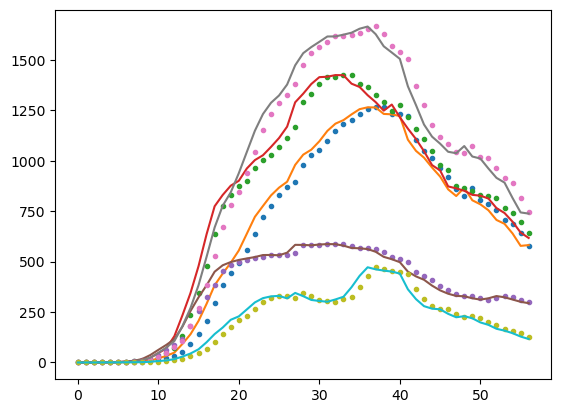

In [61]:
for i in range(yhat_array.shape[1]):
    plt.plot(yhat_array[:,i], '.')
    plt.plot(y_array[:,i])